In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.stats import norm
import pylab
tf.compat.v1.disable_eager_execution()

In [10]:
dimension_state = 1

riskfree_rate = 0.05
volatility = 0.25
strike_price = 0.5

# Time limits
T_min = 0.
T_max  = 1.

# Space limits
S_min = 1e-10 
S_max = 1.

# Network parameters
nr_layers = 3
nr_nodes_per_layer = 50
initial_learning_rate = 0.001
learning_rate_decay_steps = 10000
learning_rate_decay_rate = 0.9

# Training parameters
steps_per_sample = 10
nr_epochs = 1000

# Number of samples
N_interior = 15000
N_initial = 15000

In [11]:
# DGM neural network model
class DNN(tf.keras.Model):#creating a class called DNN
    def __init__(self, nr_layers, nr_nodes_each_layer, state_dimension=1):#init is similiar to a constructor in c++
        #self allows you to call instances of that class similar to a this pointer.
        tf.keras.Model.__init__(self)#calls the parent constructor
        self.nr_layers = nr_layers #assinging member variables nr_layers as input varaible 

        self.initial_layer = DenseLayer(state_dimension + 1, nr_nodes_each_layer, activation=tf.nn.tanh)
        #setting parameters for initial layers start from 2(state dimension +time(1)) nodes all the way to 50 nodes
        self.hidden_layers = []
        for _ in range(nr_layers): #iterating over the 3 layers
            self.hidden_layers.append(LayerFromPaper(state_dimension + 1, nr_nodes_each_layer, activation=tf.nn.tanh))#appending the hidden layers create 3 of them
        self.final_layer = DenseLayer(nr_nodes_each_layer, 1, activation=None)#create the last layer


    def call(self, t, x):# creating of a member function
        X = tf.concat([t,x], 1) # concats the time and stock price in columns

        S = self.initial_layer.call(X)#call is a member function of dense layer
        for i in range(self.nr_layers):
            S = self.hidden_layers[i].call({'S': S, 'X': X})#creating the hidden layers, #X=time and asset price we concat this in  X = tf.concat([t,x], 1)
        result = self.final_layer.call(S)#creating the final layer

        return result
    


# Neural network layers

class DenseLayer(tf.keras.layers.Layer):# creating the class Dense layers
    def __init__(self, nr_inputs, nr_outputs, activation): #creating the constructor for that class
        tf.keras.layers.Layer.__init__(self)#initialzing the object of that class
        
        self.initializer = tf.keras.initializers.glorot_normal
        #self.initializer=tf.contrib.layers.xavier_initializer()) #TF 1

        self.nr_inputs = nr_inputs# initilaizing nr_inputs as a member variable
        self.nr_outputs = nr_outputs # initilizing nr_outputs as a member varaible
        
        self.W = self.add_variable("W", shape=[self.nr_inputs, self.nr_outputs],
                                   initializer=self.initializer())# initializing W as a member variable creating a matrix type object in order to train it for the neural network
        #W is one of the weights
        self.b = self.add_variable("b", shape=[1, self.nr_outputs])  #bias or constant added only at the end of training as therefore has no initilization

        self.activation = activation #saving it as a member variable
    
    
    def call(self, inputs):#member function of Dense Layer
        S = tf.add(tf.matmul(inputs, self.W), self.b) #From paper
        if not self.activation == None:
            S = self.activation(S) #activation function with the sigma (not volatility)

        return S



class LayerFromPaper(tf.keras.layers.Layer):
    def __init__(self, nr_inputs, nr_outputs, activation):
        tf.keras.layers.Layer.__init__(self)

        self.initializer = tf.keras.initializers.glorot_normal
        #self.initializer=tf.contrib.layers.xavier_initializer()) #TF 1
        
        self.nr_outputs = nr_outputs
        self.nr_inputs = nr_inputs

        self.Uz = self.add_variable("Uz", shape=[self.nr_inputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.Ug = self.add_variable("Ug", shape=[self.nr_inputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.Ur = self.add_variable("Ur", shape=[self.nr_inputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.Uh = self.add_variable("Uh", shape=[self.nr_inputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.Wz = self.add_variable("Wz", shape=[self.nr_outputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.Wg = self.add_variable("Wg", shape=[self.nr_outputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.Wr = self.add_variable("Wr", shape=[self.nr_outputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.Wh = self.add_variable("Wh", shape=[self.nr_outputs, self.nr_outputs],
                                    initializer=self.initializer())
        self.bz = self.add_variable("bz", shape=[1, self.nr_outputs])
        self.bg = self.add_variable("bg", shape=[1, self.nr_outputs])
        self.br = self.add_variable("br", shape=[1, self.nr_outputs])
        self.bh = self.add_variable("bh", shape=[1, self.nr_outputs])

        self.activation = activation

    
    def call(self, inputs):
        S = inputs['S']
        X = inputs['X']

        Z = self.activation(tf.add(tf.add(tf.matmul(X, self.Uz), tf.matmul(S, self.Wz)), self.bz))
        G = self.activation(tf.add(tf.add(tf.matmul(X, self.Ug), tf.matmul(S, self.Wg)), self.bg))
        R = self.activation(tf.add(tf.add(tf.matmul(X, self.Ur), tf.matmul(S, self.Wr)), self.br))
        H = self.activation(tf.add(tf.add(tf.matmul(X, self.Uh), tf.matmul(tf.multiply(S, R), self.Wh)), self.bh))
        Snew = tf.add(tf.multiply(tf.subtract(tf.ones_like(G), G), H), tf.multiply(Z, S))

        return Snew

In [12]:
# Loss function
def get_residual(model, t_interior, x_interior, t_initial, x_initial):#model =BS Model,t_interior=time from 0 to 1,
    #x_interior=stock price from min to max, t_initial =t_min, x_initial=S_min
    # Loss term #1: PDE
    V = model(t_interior, x_interior)# valuation of the neural network
    V_t = tf.gradients(V, t_interior)[0] # DV/DT
    V_x = tf.gradients(V, x_interior)[0] # DV/DS
    V_xx = tf.gradients(V_x, x_interior)[0] #D^2V/DS^2
    #black scholes formula
    f = -V_t + riskfree_rate * V -riskfree_rate*x_interior*V_x - 0.5*volatility**2 * x_interior**2 * V_xx

    L1 = tf.reduce_mean(tf.square(f)) #mean of the squared residuals, residuals of the PDE J(F) part 1
    #Payoff function
    payoff= tf.math.maximum(0.,tf.subtract(x_interior,strike_price))
    #L2 norm
    L2=tf.reduce_mean(tf.square(tf.math.maximum(0.,payoff-V)))#J(f) part 2
    #max deviation of L2
    Max_dev=tf.math.reduce_max(tf.math.maximum(0.,payoff-V))
    #min deviation of L2
    Min_dev=tf.math.reduce_min(tf.math.maximum(0.,payoff-V))
    # Loss term #3: initial/terminal condition
    L3 = tf.reduce_mean(tf.square(model(t_initial,x_initial) - tf.math.maximum(0., x_initial - strike_price))) # J(F) part 3

    return (Max_dev,L1,L2,L3)


In [13]:
#  Sampling
def get_monte_carlo_points(N_interior, N_initial):
    # Sampler #1: PDE domain
    t_interior = np.random.uniform(low=T_min - 0.5*(T_max - T_min),
                           high=T_max,
                           size=[N_interior,1])
    s_interior = np.random.uniform(low=S_min - (S_max - S_min)*0.5,
                           high=S_max + (S_max - S_min)*0.5,
                           size=[N_interior,1])
    #you take all the t and the state space
    
    # Sampler #2: initial/terminal condition
    t_initial = T_max * np.ones((N_initial,1)) #Terminal condition
    s_initial = np.random.uniform(low=S_min - (S_max - S_min)*0.5,
                           high=S_max + (S_max - S_min)*0.5,
                           size=[N_initial,1])
    
    return (t_interior, s_interior, t_initial, s_initial)

In [14]:
def one_dimensional_bs_solution(time, state, strike_price, volatility, riskfree_rate):
    drift = riskfree_rate
    if np.size(volatility) == 1:  # scalar sigma
        volatility = volatility * np.ones(np.shape(time))
    if np.size(strike_price) == 1:  # scalar sigma
        strike_price = strike_price * np.ones(np.shape(time))
    if np.size(drift) == 1:  # scalar sigma
        drift = drift * np.ones(np.shape(time))
    if np.size(riskfree_rate) == 1:  # scalar sigma
        riskfree_rate = riskfree_rate * np.ones(np.shape(time))

    solution = np.zeros(np.shape(time))
    d1 = np.zeros(np.shape(time))
    d2 = np.zeros(np.shape(time))

    is_initial_time = (time == 0)
    is_zero = (state == 0)
    is_not_special_case = (time > 0) & (state > 0)

    d1[is_not_special_case] = 1. / (volatility[is_not_special_case] * np.sqrt(time[is_not_special_case])) * (
            np.log(state[is_not_special_case] / strike_price[is_not_special_case]) + (
            drift[is_not_special_case] + volatility[is_not_special_case] ** 2 * 0.5) * time[is_not_special_case])
    d2[is_not_special_case] = d1[is_not_special_case] \
                              - volatility[is_not_special_case] * np.sqrt(time[is_not_special_case])

    solution[is_not_special_case] = state[is_not_special_case] * norm.cdf(d1[is_not_special_case]) - strike_price[
        is_not_special_case] * np.exp(-riskfree_rate[is_not_special_case] * time[is_not_special_case]) * norm.cdf(
        d2[is_not_special_case])

    solution[is_initial_time] = np.maximum(0, state[is_initial_time] - strike_price[is_initial_time])
    solution[is_zero] = 0.
    return solution


In [32]:
nn_plot_list=[]
def compute_errors():
    max_error_container=[]
    mean_error_container=[]
    max_error=0
    times_to_evaluate_error=np.linspace(T_min,T_max,10)
    for t in times_to_evaluate_error:
        tt = t*np.ones_like(xplot.reshape(-1,1))
        nn_plot, = sess.run([vplot_t],
                        feed_dict={tplot_t:tt, xplot_t:xplot.reshape(-1,1)})
        nn_plot_list.append(nn_plot,)
        exact_plot = one_dimensional_bs_solution(
            T_max-tt, xplot.reshape(-1,1), strike_price, volatility, riskfree_rate)
        max_error=np.maximum(np.max(np.abs(nn_plot-exact_plot)),max_error) 
        mean_error_container.append(np.mean(np.abs(nn_plot-exact_plot)))
    New_mean_error_container=np.mean(mean_error_container)
    
    return max_error,New_mean_error_container

In [15]:
# Neural Network definition

model = DNN(nr_layers, nr_nodes_per_layer) #first time this model is constructed

t_interior_tf = tf.compat.v1.placeholder(tf.float32, shape=(None, 1), name="time_interior") #allows you to fill it with numbers
x_interior_tf = tf.compat.v1.placeholder(tf.float32, shape=(None, dimension_state), name="stock_prices_interior")
t_initial_tf = tf.compat.v1.placeholder(tf.float32, shape=(None, 1), name="time_initial")#allows you to fill it with numbers
x_initial_tf = tf.compat.v1.placeholder(tf.float32, shape=(None, dimension_state), name="stock_prices_initial")


Max_dev,residual_interior,residual_exterior,residual_initial= get_residual(model, t_interior_tf, x_interior_tf, t_initial_tf, x_initial_tf)
print("This is ")
print(residual_exterior)
print("This is ")
print(residual_interior)
residual = residual_interior + residual_initial+(residual_exterior*1) #this residual is the combination of the L1 and L2 norm
# Optimizer parameters
nr_steps = tf.Variable(0, trainable=False) #very weird itertation counter, counts the no of optimization steps we took
learning_rate = tf.compat.v1.train.exponential_decay(initial_learning_rate, nr_steps,
                                           learning_rate_decay_steps, 
                                           learning_rate_decay_rate, staircase=True)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(residual) #defining the optimizer 
# gradient descent with a momemtum term. mizimised the residuals




# Plot tensors
tplot_t = tf.compat.v1.placeholder(tf.float32, [None,1], name="tplot_t") # We name to recover it later
xplot_t = tf.compat.v1.placeholder(tf.float32, [None,1], name="xplot_t")
vplot_t = tf.identity(model(tplot_t, xplot_t), name="vplot_t") # Trick for naming the trained model


# Training data holders
residuals_list_residual0_1=[]
residuals_list_residual1_1=[]
residuals_list_residual2_1=[]
residuals_list_residual3_1=[]
residuals_list_residual4_1=[]
residuals_list_MaxDev0_1=[]
residuals_list_MaxDev1_1=[]
residuals_list_MaxDev2_1=[]
residuals_list_MaxDev3_1=[]
residuals_list_MaxDev4_1=[]
residuals_list_L10_1=[]
residuals_list_L11_1=[]
residuals_list_L12_1=[]
residuals_list_L13_1=[]
residuals_list_L14_1=[]
residuals_list_L20_1=[]
residuals_list_L21_1=[]
residuals_list_L22_1=[]
residuals_list_L23_1=[]
residuals_list_L24_1=[]
residuals_list_L30_1=[]
residuals_list_L31_1=[]
residuals_list_L32_1=[]
residuals_list_L33_1=[]
residuals_list_L34_1=[]
# Train network!!
init_op = tf.compat.v1.global_variables_initializer()




This is 
Tensor("Mean_4:0", shape=(), dtype=float32)
This is 
Tensor("Mean_3:0", shape=(), dtype=float32)


In [16]:
# before opening a tensorflow session, close the old one if possible
n=0
while n<5:
    try:
        sess.close()
    except NameError:
        pass 
    sess =  tf.compat.v1.Session()
###################################################L2 NORM is multiplied by 1#######################################
    sess.run(init_op)

    print(n)
    if n+1==1:print("This is the first run of the neural network")
    elif n+1==2:print("This is the second run of the neural network")
    elif n+1==3:print("This is the third run of the neural network")
    elif n+1==4:print("This is the fourth run of the neural network")
    elif n+1==5:print("This is the fifth run of the neural network")
    for epoch in range(nr_epochs):
        t_interior_mc, x_interior_mc, t_initial_mc, x_initial_mc = get_monte_carlo_points(N_interior, N_initial)

        for _ in range(steps_per_sample):
             Max_deviation,residual_value, residual_interior_value,residual_exterior_value,residual_initial_value, _ = \
                 sess.run([Max_dev,residual, residual_interior, residual_exterior,residual_initial, optimizer],
                          feed_dict = {t_interior_tf:t_interior_mc, x_interior_tf:x_interior_mc,
                                        t_initial_tf:t_initial_mc, x_initial_tf:x_initial_mc})
            

        if n==0:residuals_list_residual0_1.append(residual_value),residuals_list_MaxDev0_1.append(Max_deviation),residuals_list_L10_1.append(residual_interior_value),residuals_list_L20_1.append(residual_exterior_value),residuals_list_L30_1.append(residual_initial_value)
        elif n==1:residuals_list_residual1_1.append(residual_value),residuals_list_MaxDev1_1.append(Max_deviation),residuals_list_L11_1.append(residual_interior_value),residuals_list_L21_1.append(residual_exterior_value),residuals_list_L31_1.append(residual_initial_value)
        elif n==2:residuals_list_residual2_1.append(residual_value),residuals_list_MaxDev2_1.append(Max_deviation),residuals_list_L12_1.append(residual_interior_value),residuals_list_L22_1.append(residual_exterior_value),residuals_list_L32_1.append(residual_initial_value)
        elif n==3:residuals_list_residual3_1.append(residual_value),residuals_list_MaxDev3_1.append(Max_deviation),residuals_list_L13_1.append(residual_interior_value),residuals_list_L23_1.append(residual_exterior_value),residuals_list_L33_1.append(residual_initial_value)
        elif n==4:residuals_list_residual4_1.append(residual_value),residuals_list_MaxDev4_1.append(Max_deviation),residuals_list_L14_1.append(residual_interior_value),residuals_list_L24_1.append(residual_exterior_value),residuals_list_L34_1.append(residual_initial_value)

        if (not np.mod(epoch, 100)) or epoch+1==nr_epochs:
            print("Stage: {:04d}, Loss: {:e}, Maximum_Deviation: {:e}, L1: {:e}, L2: {:e}, L3: {:e}".format(
                epoch,residual_value,Max_deviation, residual_interior_value,residual_exterior_value,residual_initial_value) )
    n=n+1

0
This is the first run of the neural network
Stage: 0000, Loss: 1.573538e-01, Maximum_Deviation: 8.916432e-02, L1: 3.531863e-02, L2: 6.568969e-04, L3: 1.213783e-01
Stage: 0100, Loss: 2.459718e-04, Maximum_Deviation: 3.313786e-02, L1: 2.614753e-05, L2: 2.190400e-05, L3: 1.979203e-04
Stage: 0200, Loss: 1.353633e-04, Maximum_Deviation: 1.623502e-02, L1: 2.691929e-05, L2: 8.781412e-06, L3: 9.966255e-05
Stage: 0300, Loss: 6.680908e-05, Maximum_Deviation: 9.973019e-03, L1: 1.388498e-05, L2: 2.675649e-06, L3: 5.024845e-05
Stage: 0400, Loss: 3.025879e-05, Maximum_Deviation: 8.003861e-03, L1: 2.613227e-06, L2: 1.359549e-06, L3: 2.628601e-05
Stage: 0500, Loss: 1.550641e-05, Maximum_Deviation: 5.911604e-03, L1: 2.462242e-06, L2: 4.286181e-07, L3: 1.261555e-05
Stage: 0600, Loss: 9.722059e-06, Maximum_Deviation: 5.503193e-03, L1: 1.623056e-06, L2: 2.105233e-07, L3: 7.888480e-06
Stage: 0700, Loss: 6.519087e-06, Maximum_Deviation: 4.876167e-03, L1: 1.110279e-06, L2: 9.873913e-08, L3: 5.310069e-06
St

In [17]:
# Plot results
N = 41      # Points on plot grid

times_to_plot = [0*T_max, 0.33*T_max, 0.66*T_max, T_max]
tplot = np.linspace(T_min, T_max, N) # for surface plot
xplot = np.linspace(S_min, S_max, N)


In [50]:
max_error_1,New_mean_error_container_1=compute_errors()
print(max_error_1)
print(New_mean_error_container_1)

0.013237118671008297
0.0012194242000503346


In [21]:
print("The mean residuals from the run of 5 neural networks where L2 is multiplied by 1 is")
residual_mean_1=(residuals_list_residual0_1[-1]+residuals_list_residual1_1[-1]+residuals_list_residual2_1[-1]+residuals_list_residual3_1[-1]+residuals_list_residual4_1[-1])/5   
print(residual_mean_1)
print("The mean maximum deviation from the run of 5 neural networks where L2 is multiplied by 1 is")
max_deviation_mean_1=[(residuals_list_MaxDev0_1[-1]+residuals_list_MaxDev1_1[-1]+residuals_list_MaxDev2_1[-1]+residuals_list_MaxDev3_1[-1]+residuals_list_MaxDev4_1[-1])/5]
print(max_deviation_mean_1)
print("The mean L1 norm from the run of 5 neural networks where L1 is multiplied by 1 is ")
L1_mean_1=[(residuals_list_L10_1[-1]+residuals_list_L11_1[-1]+residuals_list_L12_1[-1]+residuals_list_L13_1[-1]+residuals_list_L14_1[-1])/5]
print(L1_mean_1)
print("The mean L2 norm from the run of 5 neural networks where L2 is multiplied by 1 is ")
L2_mean_1=[(residuals_list_L20_1[-1]+residuals_list_L21_1[-1]+residuals_list_L22_1[-1]+residuals_list_L23_1[-1]+residuals_list_L24_1[-1])/5]
print(L2_mean_1)
print("The mean L3 norm from the run of 5 neural networks where L3 is multiplied by 1 is ")
L3_mean_1=[(residuals_list_L30_1[-1]+residuals_list_L31_1[-1]+residuals_list_L32_1[-1]+residuals_list_L33_1[-1]+residuals_list_L34_1[-1])/5]
print(L3_mean_1)

The mean residuals from the run of 5 neural networks where L2 is multiplied by 1 is
3.3589007216505705e-06
The mean maximum deviation from the run of 5 neural networks where L2 is multiplied by 1 is
[0.0038023471832275392]
The mean L1 norm from the run of 5 neural networks where L1 is multiplied by 1 is 
[9.493480320088565e-07]
The mean L2 norm from the run of 5 neural networks where L2 is multiplied by 1 is 
[6.246007160370936e-08]
The mean L3 norm from the run of 5 neural networks where L3 is multiplied by 1 is 
[2.3470925953006373e-06]


In [22]:
print("The standard deviation of the residuals from the run of the 5 neural networks is")
residual_std_residuals=np.std([residuals_list_residual0_1[-1],residuals_list_residual1_1[-1],residuals_list_residual2_1[-1],residuals_list_residual3_1[-1],residuals_list_residual4_1[-1]])
print(residual_std_residuals)
print("The standard deviation of the maximum deviation from the run of 5 neural networks where L2 is multiplied by 1 is")
residual_std_max_deviation=np.std([residuals_list_MaxDev0_1[-1],residuals_list_MaxDev1_1[-1],residuals_list_MaxDev2_1[-1],residuals_list_MaxDev3_1[-1],residuals_list_MaxDev4_1[-1]])
print(residual_std_max_deviation)
print("The mean L1 norm from the run of 5 neural networks where L1 is multiplied by 1 is ")
residual_std_L1=np.std([residuals_list_L10_1[-1],residuals_list_L11_1[-1],residuals_list_L12_1[-1],residuals_list_L13_1[-1],residuals_list_L14_1[-1]])
print(residual_std_L1)
print("The mean L2 norm from the run of 5 neural networks where L2 is multiplied by 1 is ")
residual_std_L2=np.std([residuals_list_L20_1[-1],residuals_list_L21_1[-1],residuals_list_L22_1[-1],residuals_list_L23_1[-1],residuals_list_L24_1[-1]])
print(residual_std_L2)
print("The mean L3 norm from the run of 5 neural networks where L3 is multiplied by 1 is ")
residual_std_L3=np.std([residuals_list_L30_1[-1],residuals_list_L31_1[-1],residuals_list_L32_1[-1],residuals_list_L33_1[-1],residuals_list_L34_1[-1]])
print(residual_std_L3)


The standard deviation of the residuals from the run of the 5 neural networks is
7.629316e-07
The standard deviation of the maximum deviation from the run of 5 neural networks where L2 is multiplied by 1 is
0.00056238665
The mean L1 norm from the run of 5 neural networks where L1 is multiplied by 1 is 
3.1893904e-07
The mean L2 norm from the run of 5 neural networks where L2 is multiplied by 1 is 
7.718326e-08
The mean L3 norm from the run of 5 neural networks where L3 is multiplied by 1 is 
4.0798218e-07


In [56]:
stats=[]
stats.append({"The mean residuals from the run of 5 neural networks where L2 is multiplied by 1 is":residual_mean_1})
stats.append({"The mean maximum deviation from the run of 5 neural networks where L2 is multiplied by 1 is":max_deviation_mean_1})
stats.append({"The mean L1 norm from the run of 5 neural networks where L1 is multiplied by 1 is ":L1_mean_1})
stats.append({"The mean L2 norm from the run of 5 neural networks where L2 is multiplied by 1 is ":L2_mean_1})
stats.append({"The mean L3 norm from the run of 5 neural networks where L3 is multiplied by 1 is ":L3_mean_1})
stats.append({"The standard deviation of the residuals from the run of the 5 neural networks where L2 is multiplied by 1 is:":residual_std_residuals})
stats.append({"The standard deviation of the maximum deviation from the run of 5 neural networks where L2 is multiplied by 1 is":residual_std_max_deviation})
stats.append({"The standard deviation of the L1 norm from the run of 5 neural networks where L1 is multiplied by 1 is ":residual_std_L1})
stats.append({"The standard deviation of the L2 norm from the run of 5 neural networks where L2 is multiplied by 1 is ":residual_std_L2})
stats.append({"The standards deviation of the L3 norm from the run of 5 neural networks where L3 is multiplied by 1 is ":residual_std_L3})
np.savetxt("L2_norm_stats_max_samples_call_option.txt", stats, delimiter=" ", newline = "\n", fmt="%s")

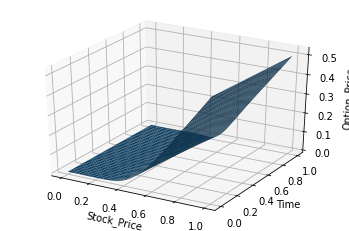

In [64]:
x_grid, t_grid = np.meshgrid(xplot, tplot, sparse=False, indexing='ij')
nn_plot = sess.run(vplot_t,
                    feed_dict={tplot_t:t_grid.reshape(-1,1),
                               xplot_t:x_grid.reshape(-1,1)}).reshape(N,N)

fig = pylab.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X=x_grid, Y=t_grid, Z=nn_plot)
ax.set_xlabel('Stock_Price')
ax.set_ylabel('Time')
ax.set_zlabel('Option_Price')
plt.savefig('3D_Neural_Network_Call_Option.png', dpi=100, bbox_inches='tight')

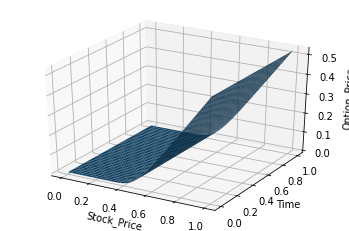

In [65]:
x_grid, t_grid = np.meshgrid(xplot, tplot, sparse=False, indexing='ij')
exact_plot = one_dimensional_bs_solution(
       tplot.reshape(-1,1), xplot.reshape(-1,1), strike_price, volatility, riskfree_rate)
fig = pylab.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X=x_grid, Y=t_grid, Z=exact_plot)
ax.set_xlabel('Stock_Price')
ax.set_ylabel('Time')
ax.set_zlabel('Option_Price')
plt.savefig('BS_Solution_Call_Option.png', dpi=100, bbox_inches='tight')

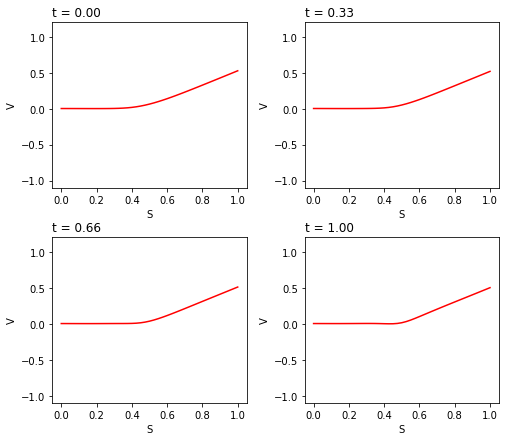

In [25]:
plt.figure(figsize=(8,7))
i = 1
for t in times_to_plot:
    tt = t*np.ones_like(xplot.reshape(-1,1))
    nn_plot, = sess.run([vplot_t],
                        feed_dict={tplot_t:tt, xplot_t:xplot.reshape(-1,1)})

    plt.subplot(2,2,i)
    plt.plot(xplot, nn_plot, 'r')

    plt.ylim(-1.1, 1.2)
    plt.xlabel("S")
    plt.ylabel("V")
    plt.title("t = %.2f"%t, loc="left")
    i = i+1

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

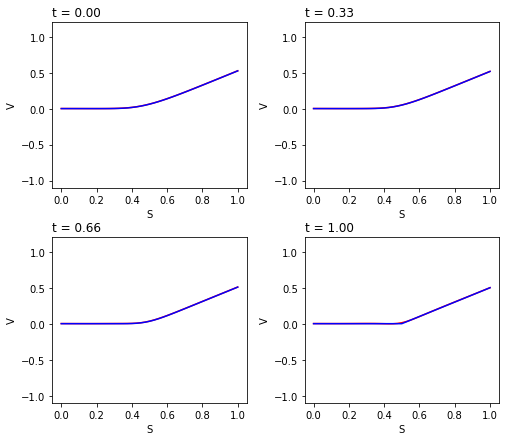

In [59]:
plt.figure(figsize=(8,7))
i = 1
for t in times_to_plot:
    tt = t*np.ones_like(xplot.reshape(-1,1))
    nn_plot, = sess.run([vplot_t],
                        feed_dict={tplot_t:tt, xplot_t:xplot.reshape(-1,1)})

    exact_plot = one_dimensional_bs_solution(
        T_max-tt, xplot.reshape(-1,1), strike_price, volatility, riskfree_rate)
    
    plt.subplot(2,2,i)
    plt.plot(xplot, nn_plot, 'r')
    plt.plot(xplot, exact_plot, 'b')

    plt.ylim(-1.1, 1.2)
    plt.xlabel("S")
    plt.ylabel("V")
    plt.title("t = %.2f"%t, loc="left")
    i = i+1

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('L2*1_comparison_call_option_max_samples.png', dpi=50, bbox_inches='tight')
plt.show()

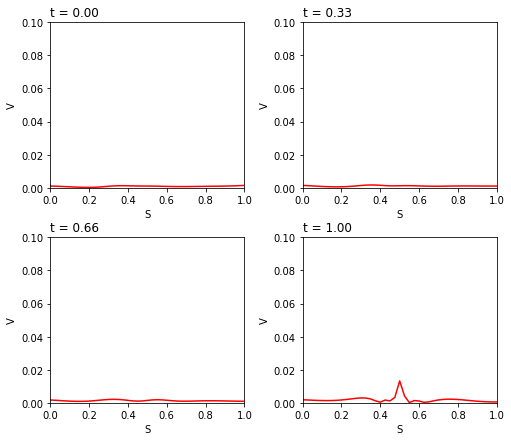

In [60]:
plt.figure(figsize=(8,7))
i = 1
for t in times_to_plot:
    tt = t*np.ones_like(xplot.reshape(-1,1))
    nn_plot, = sess.run([vplot_t],
                        feed_dict={tplot_t:tt, xplot_t:xplot.reshape(-1,1)})

    exact_plot = one_dimensional_bs_solution(
        T_max-tt, xplot.reshape(-1,1), strike_price, volatility, riskfree_rate)
    
    plt.subplot(2,2,i)
    plt.plot(xplot, abs(nn_plot-exact_plot), 'r')

    plt.ylim(0, 0.1)
    plt.xlim(0, 1)
    plt.xlabel("S")
    plt.ylabel("V")
    plt.title("t = %.2f"%t, loc="left")
    i = i+1

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.savefig('L2*1_error_call_option_max_samples.png', dpi=50, bbox_inches='tight')
plt.show()